In [1]:
!pip install pennylane --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 26.5 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [3]:
import os
import random

def set_seed(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [38]:
seed = 123
set_seed(seed)

In [5]:
from scipy.linalg import expm

In [6]:
def Linb_meas(t_tensor):  # t_tensor: [n, 1] tensor
    t_array = t_tensor.detach().cpu().numpy().flatten()  # Convert to (n,) numpy array

    def kron3(a, b, c):
        return np.kron(np.kron(a, b), c)

    # Pauli matrices
    I0, X0, Y0, Z0 = [qml.matrix(op) for op in (qml.Identity(0), qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0))]
    I1, X1, Y1, Z1 = [qml.matrix(op) for op in (qml.Identity(1), qml.PauliX(1), qml.PauliY(1), qml.PauliZ(1))]
    I2, X2, Y2, Z2 = [qml.matrix(op) for op in (qml.Identity(2), qml.PauliX(2), qml.PauliY(2), qml.PauliZ(2))]

    # Hamiltonian parameters
    h = 2 * np.pi
    Jx = Jy = Jz = 0.1 * np.pi

    # Hamiltonian H
    H = -(h / 2) * (kron3(Z0, I1, I2) + kron3(I0, Z1, I2) + kron3(I0, I1, Z2)).astype(np.complex128)
    H -= 0.5 * Jx * (kron3(X0, X1, I2) + kron3(I0, X1, X2))
    H -= 0.5 * Jy * (kron3(Y0, Y1, I2) + kron3(I0, Y1, Y2))
    H -= 0.5 * Jz * (kron3(Z0, Z1, I2) + kron3(I0, Z1, Z2))

    # Lindblad operators
    c = np.sqrt(0.002)
    C_ops = [
        c * (kron3(X0, I1, I2) + kron3(Y0, I1, I2)),
        c * (kron3(I0, X1, I2) + kron3(I0, Y1, I2)),
        c * (kron3(I0, I1, X2) + kron3(I0, I1, Y2)),
    ]

    # Liouvillian superoperator
    dim = 8
    I_sys = np.eye(dim)
    L = -1j * (np.kron(H, I_sys) - np.kron(I_sys, H.T))
    for C in C_ops:
        CdagC = C.conj().T @ C
        L += 0.5 * (2 * np.kron(C, C.conj()) - np.kron(I_sys, CdagC.T) - np.kron(CdagC, I_sys))

    # Initial state |+00⟩
    ket_plus = (1 / np.sqrt(2)) * np.array([1, 1])
    ket_0 = np.array([1, 0])
    psi = np.kron(np.kron(ket_plus, ket_0), ket_0)
    rho0 = np.outer(psi, psi.conj())
    rho0_vec = rho0.reshape(-1)

    # Observable X on qubit 0
    X1_obs = kron3(X0, I1, I2)

    results = []
    for t in t_array:
        U = expm(L * t)
        rho_t_vec = U @ rho0_vec
        rho_t = rho_t_vec.reshape(dim, dim)
        x_t = np.real(np.trace(X1_obs @ rho_t))
        results.append(x_t)

    # Return torch tensor of shape [n, 1]
    return torch.tensor(results, dtype=torch.float32).unsqueeze(-1)


In [7]:
class LinbDataset(Dataset):
    def __init__(self, x_0, x_1, x_2, y):
        self.x_0 = x_0
        self.x_1 = x_1
        self.x_2 = x_2
        self.y = y

    def __len__(self):
        return len(self.x_0)

    def __getitem__(self, idx):
        return self.x_0[idx], self.x_1[idx], self.x_2[idx], self.y[idx]

In [8]:
class LinbDataGenerator:
    def __init__(self, num_samples=3000, n_ancilla=3, multiplicity=1, ratio=0.8):
        assert num_samples % 5 == 0, "num_samples must be a multiple of 5"
        self.num_samples = num_samples
        self.n_ancilla = n_ancilla
        self.multiplicity = multiplicity
        self.ratio = ratio
        self.delta = math.pi / (2 * 3 * num_samples)  # Step size

        # Precompute datasets
        self.train_data = self._generate_sequence('train')
        self.test_data = self._generate_sequence('test')

    def _generate_sequence(self, dataset_type):
        if dataset_type == 'train':
            start = 0
            end = self.ratio * (math.pi / 2) - 4 * self.delta
            steps = int(self.ratio * self.num_samples)
        else:
            start = self.ratio * (math.pi / 2)
            end = math.pi / 2 - 4 * self.delta
            steps = self.num_samples - int(self.ratio * self.num_samples)

        x0_data = torch.linspace(start, end, steps)
        x1_data = x0_data + 1 * self.delta
        x2_data = x0_data + 2 * self.delta
        x3_data = x0_data + 3 * self.delta

        y1_data = Linb_meas(self.multiplicity * x1_data.unsqueeze(-1)) # Ensure input is [num_samples, 1]
        y2_data = Linb_meas(self.multiplicity * x2_data.unsqueeze(-1))
        y3_data = Linb_meas(self.multiplicity * x3_data.unsqueeze(-1))
        target_seq = torch.cat([y1_data, y2_data, y3_data], dim=1) # Shape [num_samples, 3]

        input_seq_0 = Linb_meas(self.multiplicity*x0_data.unsqueeze(-1)) # Shape [num_samples, 1]
        input_seq_1 = Linb_meas(self.multiplicity*x1_data.unsqueeze(-1))
        input_seq_2 = Linb_meas(self.multiplicity*x2_data.unsqueeze(-1))

        return input_seq_0, input_seq_1, input_seq_2, target_seq

    def get_loaders(self, batch_size=32):
        train_dataset = LinbDataset(*self.train_data)
        test_dataset = LinbDataset(*self.test_data)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        return train_loader, test_loader

In [9]:
generator = LinbDataGenerator()
train_loader, test_loader = generator.get_loaders(batch_size=64)

In [57]:
class QSSMLayer(nn.Module):
    def __init__(self, n_ancilla=3, n_layers=6, backend="default.qubit"):
        super(QSSMLayer, self).__init__()

        self.n_ancilla = n_ancilla # number of ancilla qubits
        self.n_layers = n_layers # number of repeated blocks in U_B

        self.n_q1 = 1 + n_ancilla # 1 dimensional input + ancillae
        self.n_q2 = 2 * self.n_q1
        self.n_q3 = 3 * self.n_q1

        self.dev1 = qml.device(backend, wires=self.n_q1)
        self.dev2 = qml.device(backend, wires=self.n_q2)
        self.dev3 = qml.device(backend, wires=self.n_q3)

#step 1
        def circuit_1(inputs, r_z_1, r_x, r_z_2, c_r_z, U_B, U_A, r_y, c_r_y):

            qml.AngleEmbedding(inputs, wires=range(self.n_q1), rotation='Y') # angle embedding by rotation Y

            for l in range(self.n_layers):
                for i in range(self.n_q1):

                    qml.RX(r_z_1[l, i, :], wires=i)
                    qml.RZ(r_x[l, i, :], wires=i)
                    qml.RX(r_z_2[l, i, :], wires=i)

                    if i< self.n_q1 - 1:
                      qml.CRZ(c_r_z[l, i, :], wires = [i+1, i] )
                    if i == self.n_q1 - 1:
                      qml.CRZ(c_r_z[l, i, :], wires = [0, i])

            for i in range(self.n_q1):

                qml.RY(r_y[i], wires=i) # rotate Y every wrire

                if i < self.n_q1 - 1:
                  qml.CRY(c_r_y[i], wires=[i+1, i]) # chain of controlled Y gates

                if i == self.n_q1 - 1:
                  qml.CRY(c_r_y[i], wires=[0, i])

            #return [qml.expval(qml.PauliZ(i)) for i in range(self.n_q1)]
            return [qml.expval(qml.PauliZ(i)) for i in [1]]

#step 2
        def circuit_2(inputs, r_z_1, r_x, r_z_2, c_r_z, U_B, U_A, r_y, c_r_y):

            qml.AngleEmbedding(inputs, wires=range(self.n_q2), rotation='Y')

            for l in range(self.n_layers):
                for i in range(self.n_q1):

                    qml.RX(r_z_1[l, i, :], wires=i)
                    qml.RZ(r_x[l, i, :], wires=i)
                    qml.RX(r_z_2[l, i, :], wires=i)

                    if i< self.n_q1 - 1:
                      qml.CRZ(c_r_z[l, i, :], wires = [i+1, i] )
                    if i == self.n_q1 - 1:
                      qml.CRZ(c_r_z[l, i, :], wires = [0, i])

            for l in range(self.n_layers):
                for i in range(self.n_q1, self.n_q2):

                    qml.RX(r_z_1[l, i - self.n_q1, :], wires=i)
                    qml.RZ(r_x[l, i - self.n_q1, :], wires=i)
                    qml.RX(r_z_2[l, i - self.n_q1, :], wires=i)

                    if i< self.n_q2 - 1:
                      qml.CRZ(c_r_z[l, i - self.n_q1, :], wires = [i+1, i] )
                    if i == self.n_q2 - 1:
                      qml.CRZ(c_r_z[l, i - self.n_q1, :], wires = [self.n_q1, i])

            # Apply e^{1*U_A[i,j] Z_i Z_j} to qubits 0 1 2
            for i in range(self.n_q1):
              for j in range(i+1, self.n_q1):
                qml.IsingZZ(U_A[i,j], wires=[i, j])

            # RY and CRY
            # wires of x_0
            for i in range(self.n_q2):

                if i < self.n_q1:

                  qml.RY(r_y[i], wires=i) # rotate Y every wrire

                  qml.CRY(c_r_y[i], wires=[i+1, i]) # chain of controlled Y gates


            # wires of x_1
                if ( i in range(self.n_q1, self.n_q2) ):

                  qml.RY(r_y[i - self.n_q1], wires=i)

                  if i < self.n_q2 - 1:
                    qml.CRY(c_r_y[i - self.n_q1], wires=[i+1, i])

                  if i == self.n_q2 - 1:
                    qml.CRY(c_r_y[i - self.n_q1], wires=[0, i])

            #return [qml.expval(qml.PauliZ(i)) for i in range(self.n_q1)]
            return [qml.expval(qml.PauliZ(i)) for i in [1]]

# step 3
        def circuit_3(inputs, r_z_1, r_x, r_z_2, c_r_z, U_B, U_A, r_y, c_r_y):

            qml.AngleEmbedding(inputs, wires=range(self.n_q3), rotation='Y')

            for l in range(self.n_layers):
                for i in range(self.n_q1):

                    qml.RX(r_z_1[l, i, :], wires=i)
                    qml.RZ(r_x[l, i, :], wires=i)
                    qml.RX(r_z_2[l, i, :], wires=i)

                    if i< self.n_q1 - 1:
                      qml.CRZ(c_r_z[l, i, :], wires = [i+1, i] )
                    if i == self.n_q1 - 1:
                      qml.CRZ(c_r_z[l, i, :], wires = [0, i])


            for l in range(self.n_layers):
                for i in range(self.n_q1, self.n_q2):

                    qml.RX(r_z_1[l, i - self.n_q1, :], wires=i)
                    qml.RZ(r_x[l, i - self.n_q1, :], wires=i)
                    qml.RX(r_z_2[l, i - self.n_q1, :], wires=i)

                    if i< self.n_q2 - 1:
                      qml.CRZ(c_r_z[l, i - self.n_q1, :], wires = [i+1, i] )
                    if i == self.n_q2 - 1:
                      qml.CRZ(c_r_z[l, i - self.n_q1, :], wires = [self.n_q1, i])


            for l in range(self.n_layers):
                for i in range(self.n_q2, self.n_q3):
                    qml.RX(r_z_1[l, i - self.n_q2, :], wires=i)
                    qml.RZ(r_x[l, i - self.n_q2, :], wires=i)
                    qml.RX(r_z_2[l, i - self.n_q2, :], wires=i)

                    if i< self.n_q3 - 1:
                      qml.CRZ(c_r_z[l, i - self.n_q2, :], wires = [i+1, i] )
                    if i == self.n_q3 - 1:
                      qml.CRZ(c_r_z[l, i - self.n_q2, :], wires = [self.n_q2, i])


            # Apply e^{2*U_A[i,j] Z_i Z_j} to qubits 0 1 2
            for i in range(self.n_q1):
              for j in range(i+1, self.n_q1):
                qml.IsingZZ(2*U_A[i, j], wires=[i, j])


            # Apply e^{1*U_A[i,j] Z_i Z_j} to qubits 3 4 5
            for i in range(self.n_q1, self.n_q2):
              for j in range(i+1, self.n_q2):
                # Calculate relative indices for U_A
                i_rel = i - self.n_q1
                j_rel = j - self.n_q1
            # Check bounds before accessing U_A
                if i_rel < U_A.shape[0] and j_rel < U_A.shape[1]:
                  qml.IsingZZ(U_A[i_rel, j_rel], wires=[i, j])

            # RY and CRY
            # wires of x_0
            for i in range(self.n_q3):
                if i < self.n_q1:

                  qml.RY(r_y[i], wires=i) # rotate Y every wrire

                  qml.CRY(c_r_y[i], wires=[i+1, i]) # chain of controlled Y gates


            # wires of x_1
                if i in range(self.n_q1, self.n_q2):

                  qml.RY(r_y[i - self.n_q1], wires=i)

                  qml.CRY(c_r_y[i - self.n_q1], wires=[i+1, i]) # chain of controlled Y gates


            # wires of x_2
                if i in range(self.n_q2, self.n_q3):
                  qml.RY(r_y[i - self.n_q2], wires=i) # rotate Y every wrire

                  if i < self.n_q3 - 1:
                    qml.CRY(c_r_y[i - self.n_q2], wires=[i+1, i]) # chain of controlled Y gates

                  if i == self.n_q3 - 1:
                    qml.CRY(c_r_y[i - self.n_q2], wires=[0, i])


            #return [qml.expval(qml.PauliZ(i)) for i in range(self.n_q1)]
            return [qml.expval(qml.PauliZ(i)) for i in [1]]

        weight_shapes = {
            "r_z_1": (self.n_layers, self.n_q1, 1),
            "r_x": (self.n_layers, self.n_q1, 1),
            "r_z_2": (self.n_layers, self.n_q1, 1),
            "c_r_z": (self.n_layers, self.n_q1, 1),
            "U_B": (self.n_layers, 1, self.n_q1),
            "U_A":(self.n_q1, self.n_q1),
            "r_y": (self.n_q1, 1),
            "c_r_y": (self.n_q1, 1),
        }
        # Add initialization

        self.qlayer_1 = qml.qnn.TorchLayer(qml.QNode(circuit_1, self.dev1, interface="torch"), weight_shapes)
        self.qlayer_2 = qml.qnn.TorchLayer(qml.QNode(circuit_2, self.dev2, interface="torch"), weight_shapes)
        self.qlayer_3 = qml.qnn.TorchLayer(qml.QNode(circuit_3, self.dev3, interface="torch"), weight_shapes)

        # Uniform initialization of all parameters in each quantum layer
        init_left, init_right = -.5, .5
        for layer in [self.qlayer_1, self.qlayer_2, self.qlayer_3]:
          for name, param in layer.named_parameters():
            torch.nn.init.uniform_(param, a=init_left, b=init_right)

    def forward(self, x_0, x_1, x_2):
        out_0 = torch.mean(self.qlayer_1(x_0), dim=1)  # shape: [batch_size]
        out_1 = torch.mean(self.qlayer_2(x_1), dim=1)
        out_2 = torch.mean(self.qlayer_3(x_2), dim=1)
        combined_out = torch.stack([out_0, out_1, out_2], dim=1)  # [batch_size, 3]
        return combined_out


In [58]:
model = QSSMLayer()

In [59]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=5*1e-2)

In [60]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_params(model))

432


In [61]:
loss_history = []

In [62]:
# Test random function
model.eval()
test_loss_all = 0.0
test_loss_y2 = 0.0
num_batch = 0

with torch.no_grad():
    for batch_x_0, batch_x_1, batch_x_2, batch_y in test_loader:
        output = model(batch_x_0, batch_x_1, batch_x_2)

        loss_all = criterion(output, batch_y)
        test_loss_all += loss_all.item()

        loss_y2 = criterion(output[:, 2], batch_y[:, 2]) # test only given x0 x1 x2, predict x3
        test_loss_y2 += loss_y2.item()
        num_batch += 1

    test_loss_all /= num_batch
    test_loss_y2 /= num_batch
print(f"\n Test Loss before Training (all steps): {test_loss_all:.4f}")
print(f"\n Test Loss before Training (3rd step): {test_loss_y2:.4f}")



 Test Loss before Training (all steps): 1.2642

 Test Loss before Training (3rd step): 1.1957


In [63]:
# Training
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    num_batch = 0

    for batch_x_0, batch_x_1, batch_x_2, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x_0, batch_x_1, batch_x_2)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batch += 1
    epoch_loss /= num_batch
    #if epoch%10 == 0:
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {epoch_loss:.4f}")

Epoch 1/100 - Loss: 0.4362
Epoch 2/100 - Loss: 0.3820
Epoch 3/100 - Loss: 0.3357
Epoch 4/100 - Loss: 0.3092
Epoch 5/100 - Loss: 0.2967
Epoch 6/100 - Loss: 0.2850
Epoch 7/100 - Loss: 0.2719
Epoch 8/100 - Loss: 0.2508
Epoch 9/100 - Loss: 0.2132
Epoch 10/100 - Loss: 0.1640
Epoch 11/100 - Loss: 0.1145
Epoch 12/100 - Loss: 0.0793
Epoch 13/100 - Loss: 0.0568
Epoch 14/100 - Loss: 0.0426
Epoch 15/100 - Loss: 0.0336
Epoch 16/100 - Loss: 0.0276
Epoch 17/100 - Loss: 0.0232
Epoch 18/100 - Loss: 0.0200
Epoch 19/100 - Loss: 0.0177
Epoch 20/100 - Loss: 0.0160
Epoch 21/100 - Loss: 0.0147
Epoch 22/100 - Loss: 0.0135
Epoch 23/100 - Loss: 0.0126
Epoch 24/100 - Loss: 0.0117
Epoch 25/100 - Loss: 0.0111
Epoch 26/100 - Loss: 0.0106
Epoch 27/100 - Loss: 0.0102
Epoch 28/100 - Loss: 0.0098
Epoch 29/100 - Loss: 0.0095
Epoch 30/100 - Loss: 0.0092
Epoch 31/100 - Loss: 0.0090
Epoch 32/100 - Loss: 0.0087
Epoch 33/100 - Loss: 0.0086
Epoch 34/100 - Loss: 0.0084
Epoch 35/100 - Loss: 0.0082
Epoch 36/100 - Loss: 0.0081
E

In [64]:
#Evaluation
model.eval()
test_loss_all = 0.0
test_loss_y2 = 0.0
num_batch = 0
x_3_list = []
y_2_list = []

with torch.no_grad():
    for batch_x_0, batch_x_1, batch_x_2, batch_y in test_loader:
        output = model(batch_x_0, batch_x_1, batch_x_2)

        loss_all = criterion(output, batch_y)
        test_loss_all += loss_all.item()

        loss_y2 = criterion(output[:, 2], batch_y[:, 2])
        test_loss_y2 += loss_y2.item()

        x_3_list.append(output[:, 2].tolist())
        y_2_list.append(batch_y[:, 2].tolist())

        num_batch += 1
    test_loss_all /= num_batch
    test_loss_y2 /= num_batch
print(f"\n Final test Loss (all steps): {test_loss_all:.4f}")
print(f"\n Final test Loss (3rd step): {test_loss_y2:.4f}")


 Final test Loss (all steps): 0.0074

 Final test Loss (3rd step): 0.0074


In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

In [66]:
n_steps = len(loss_history)

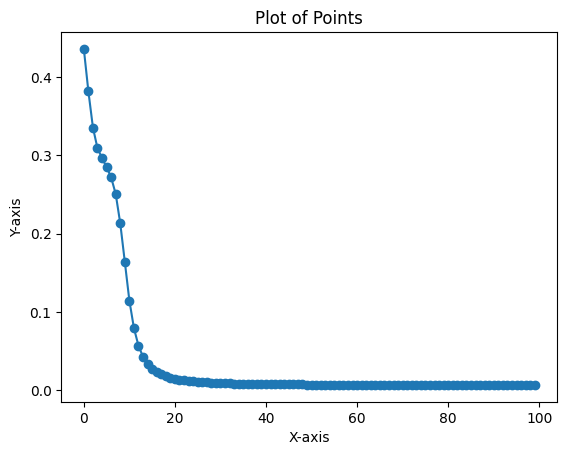

In [67]:

x_coords = [i for i in range(n_steps)]
y_coords = loss_history

plt.plot(x_coords, y_coords, c="#1f77b4", marker="o")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Plot of Points')
plt.show()

In [68]:
print(loss_history)

[0.4362299410920394, 0.38202406309152903, 0.335704238399079, 0.3091781551116391, 0.29670779563878713, 0.2850477417048655, 0.2718979296715636, 0.25078112004618897, 0.21320704096242002, 0.16401787768853338, 0.11449543131809485, 0.07933149398549606, 0.056772493414188684, 0.04256294550080048, 0.03362964255441176, 0.027642612296499704, 0.023221437280115328, 0.020045488141477108, 0.017741996280260776, 0.016033768114682875, 0.014676355070581562, 0.013466021438178263, 0.012557726573983305, 0.011732190982193538, 0.011127812898178635, 0.010648687443646946, 0.010205200456671025, 0.009817356010898948, 0.009501060801803282, 0.009197552639402841, 0.008953561405896357, 0.008732436286089452, 0.008592446040558187, 0.008403884344979337, 0.008248479620210435, 0.008142257256335333, 0.008014566424351773, 0.00787115794312405, 0.007798470372922327, 0.007737519305297418, 0.007632956190622951, 0.007592036106966828, 0.007528676773960653, 0.0074458708006300426, 0.007378647005871723, 0.00734477803895348, 0.007293

In [69]:
print(x_3_list)

[[-0.3609180152416229, -0.3635716438293457, -0.36621764302253723, -0.3688555359840393, -0.3714863657951355, -0.3741096258163452, -0.37672510743141174, -0.37933287024497986, -0.38193291425704956, -0.38452455401420593, -0.3871089518070221, -0.3896854817867279, -0.39225414395332336, -0.3948148787021637, -0.39736706018447876, -0.3999118208885193, -0.4024485647678375, -0.40497729182243347, -0.40749791264533997, -0.4100103974342346, -0.41251423954963684, -0.41501039266586304, -0.417498379945755, -0.4199781119823456, -0.42244967818260193, -0.4249122738838196, -0.4273672103881836, -0.42981377243995667, -0.4322519898414612, -0.43468180298805237, -0.4371032118797302, -0.439515620470047, -0.44192010164260864, -0.4443160891532898, -0.44670358300209045, -0.44908252358436584, -0.45145294070243835, -0.45381423830986023, -0.45616742968559265, -0.45851200819015503, -0.460847944021225, -0.4631751775741577, -0.46549326181411743, -0.46780315041542053, -0.47010424733161926, -0.4723966717720032, -0.47468027

In [70]:
print(y_2_list)

[[-0.381412148475647, -0.38426265120506287, -0.3871082067489624, -0.38994815945625305, -0.3927837014198303, -0.39561423659324646, -0.3984396755695343, -0.40126001834869385, -0.4040752053260803, -0.4068845808506012, -0.40968939661979675, -0.4124889671802521, -0.4152832627296448, -0.41807225346565247, -0.42085525393486023, -0.42363354563713074, -0.4264064133167267, -0.42917385697364807, -0.4319358468055725, -0.43469229340553284, -0.4374426305294037, -0.4401879906654358, -0.4429277777671814, -0.4456619322299957, -0.4483904242515564, -0.45111262798309326, -0.45382970571517944, -0.4565410315990448, -0.45924657583236694, -0.4619463086128235, -0.46464020013809204, -0.4673275649547577, -0.4700096547603607, -0.4726858139038086, -0.47535598278045654, -0.47802016139030457, -0.4806783199310303, -0.48332977294921875, -0.4859757721424103, -0.48861563205718994, -0.49124932289123535, -0.4938768446445465, -0.4964975416660309, -0.4991125762462616, -0.5017213821411133, -0.5043238401412964, -0.50691998004

In [71]:
file_path = 'simple_model.pth'
torch.save(model.state_dict(), file_path)

In [72]:
model1 = QSSMLayer()
model1.load_state_dict(torch.load(file_path))
model1.eval()

QSSMLayer(
  (qlayer_1): <Quantum Torch Layer: func=circuit_1>
  (qlayer_2): <Quantum Torch Layer: func=circuit_2>
  (qlayer_3): <Quantum Torch Layer: func=circuit_3>
)

In [73]:
#Evaluation
model1.eval()
test_loss_all = 0.0
test_loss_y2 = 0.0
num_batch = 0
output_list = []
y_list = []

with torch.no_grad():
    for batch_x_0, batch_x_1, batch_x_2, batch_y in test_loader:
        output = model1(batch_x_0, batch_x_1, batch_x_2)

        loss_all = criterion(output, batch_y)
        test_loss_all += loss_all.item()

        loss_y2 = criterion(output[:, 2], batch_y[:, 2])
        test_loss_y2 += loss_y2.item()

        output_list.append(output.tolist())
        y_list.append(batch_y.tolist())

        num_batch += 1
    test_loss_all /= num_batch
    test_loss_y2 /= num_batch
print(f"\n Final test Loss (all steps): {test_loss_all:.4f}")
print(f"\n Final test Loss (3rd step): {test_loss_y2:.4f}")


 Final test Loss (all steps): 0.0074

 Final test Loss (3rd step): 0.0074


In [74]:
print(output_list)

[[[-0.3589663803577423, -0.3593915104866028, -0.3609180152416229], [-0.361624151468277, -0.3620454967021942, -0.3635716438293457], [-0.36427441239356995, -0.36469191312789917, -0.36621764302253723], [-0.3669165074825287, -0.3673302233219147, -0.3688555359840393], [-0.3695516288280487, -0.3699615001678467, -0.3714863657951355], [-0.37217915058135986, -0.3725851774215698, -0.3741096258163452], [-0.374798983335495, -0.37520116567611694, -0.37672510743141174], [-0.3774111270904541, -0.3778095245361328, -0.37933287024497986], [-0.3800155818462372, -0.3804101049900055, -0.38193291425704956], [-0.38261163234710693, -0.3830023407936096, -0.38452455401420593], [-0.38520053029060364, -0.3855873942375183, -0.3871089518070221], [-0.3877815306186676, -0.38816455006599426, -0.3896854817867279], [-0.3903546929359436, -0.39073389768600464, -0.39225414395332336], [-0.39291998744010925, -0.3932953178882599, -0.3948148787021637], [-0.395476758480072, -0.39584824442863464, -0.39736706018447876], [-0.39802

In [75]:
print(y_list)

[[[-0.37950822710990906, -0.3804604709148407, -0.381412148475647], [-0.3823620080947876, -0.3833126127719879, -0.38426265120506287], [-0.38521087169647217, -0.3861598074436188, -0.3871082067489624], [-0.38805413246154785, -0.38900139927864075, -0.38994815945625305], [-0.39089304208755493, -0.3918386399745941, -0.3927837014198303], [-0.3937269151210785, -0.39467087388038635, -0.39561423659324646], [-0.39655575156211853, -0.3974980115890503, -0.3984396755695343], [-0.39937952160835266, -0.40032005310058594, -0.40126001834869385], [-0.4021981358528137, -0.4031369686126709, -0.4040752053260803], [-0.40501096844673157, -0.40594807267189026, -0.4068845808506012], [-0.4078192710876465, -0.4087546169757843, -0.40968939661979675], [-0.41062232851982117, -0.4115559458732605, -0.4124889671802521], [-0.4134201407432556, -0.4143519997596741, -0.4152832627296448], [-0.41621267795562744, -0.41714274883270264, -0.41807225346565247], [-0.41899925470352173, -0.41992756724357605, -0.42085525393486023], [